# Manga Translator

## Introduction

I love reading manga, and I can't wait for the next chapter of my favorite manga to be released. However, the newest chapters are usually in Japanese, and they are translated to English after some time. I want to read the newest chapters as soon as possible, so I decided to build a manga translator that can translate Japanese manga to English.

## Approach

I want to translate the text in the manga images from Japanese to English. I will first need to know where these speech bubbles are on the image. For this I will use `Yolov8` to detect the speech bubbles. Once I have the speech bubbles, I will use `manga-ocr` to extract the text from the speech bubbles. Finally, I will use `deep-translator` to translate the text from Japanese to English.

## Yolov12s

`Yolov12s` is a state-of-the-art, real-time object detection system. I will use `Yolov12s` to detect the speech bubbles in the manga images.

## Manga-ocr

Optical character recognition for Japanese text, with the main focus being Japanese manga. This Python package is built and trained specifically for extracting text from manga images. This makes it perfect for extracting text from the speech bubbles in the manga images.

## Deep-translator

`Deep-translator` is a Python package that uses the Google Translate API to translate text from one language to another. I will use `deep-translator` to translate the text extracted from the manga images from Japanese to English.

## Data Preparation

This [dataset](https://universe.roboflow.com/riqworld/bubble-detection-gbjon-fwla1/dataset/1) contains over 8500 images of manga pages together with their annotations from Roboflow. I will use this dataset to train `Yolov12s` to detect the speech bubbles in the manga images. To use this dataset with Yolov8, I will need to convert the annotations to the YOLO format, which is a text file containing the class label and the bounding box coordinates of the object in the image.

This dataset is over 1.7GB in size, so I will need to download it to my local machine. The rest of the code should be run after the dataset has been downloaded and extracted in this directory.

The dataset contains mostly English manga, but that is fine since I am only interested in the speech bubbles.

### Yolov8 format

```
class_index x1, y1, x2, y2, x3, y3, x4, y4
```

Where:
- `class_index` is the index of the class in the class list
- `(x1, y1), (x2, y2), (x3, y3), (x4, y4)` are the coordinates of the bounding box
- The coordinates are normalized to the range [0, 1]
- The coordinates are in the format `(x, y)`, where `x` is the horizontal coordinate and `y` is the vertical coordinate

Since the dataset is taken from Roboflow, the annotations are in the Roboflow format. I don't need to do any data preprocessing for this dataset.

## Train the model

In [ ]:
# Fine tune the model on the dataset
# from ultralytics import YOLO

# model = YOLO("yolov11s.pt")

# model.train(data="./data/data.yaml", epochs=5)

In [2]:
# load specific model, trained on GPU on Google Colab
import os
from ultralytics import YOLO

best_model_path = "./runs/detect/train"

model = YOLO(os.path.join(best_model_path, "weights/best.pt"))

## Test the model

In [3]:
from IPython.display import display
import random
from PIL import Image, ImageDraw
import os


image 1/1 /home/riq/src/python/mangatrans/model_creation/bubble-detect-dataset/test/images/-1810-_jpg.rf.e71269a025d482bc990898e45801e0a6.jpg: 640x480 6 text_bubbles, 13.5ms
Speed: 2.8ms preprocess, 13.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
Object: text_bubble
Coordinates: [381, 198, 467, 330]
Probability: 0.9271
Object: text_bubble
Coordinates: [188, 357, 262, 447]
Probability: 0.9182
Object: text_bubble
Coordinates: [284, 47, 367, 186]
Probability: 0.9174
Object: text_bubble
Coordinates: [81, 456, 151, 547]
Probability: 0.9003
Object: text_bubble
Coordinates: [16, 23, 146, 256]
Probability: 0.8939
Object: text_bubble
Coordinates: [375, 356, 439, 426]
Probability: 0.871


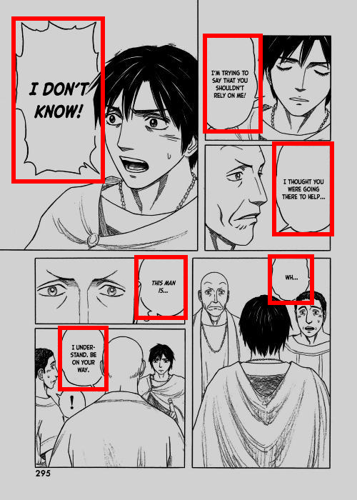

In [8]:
import random

random_image_path = random.choice(os.listdir("bubble-detect-dataset/test/images"))
image_path = f"bubble-detect-dataset/test/images/{random_image_path}"
image = Image.open(image_path)

# Perform inference
result = model.predict(image_path)[0]

# Draw the bounding boxes around the text
draw = ImageDraw.Draw(image)
for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))
	draw.rectangle(coords, outline="red", width=6)

image.thumbnail((500, 500))
display(image)

## Model Evaluations

confusion_matrix


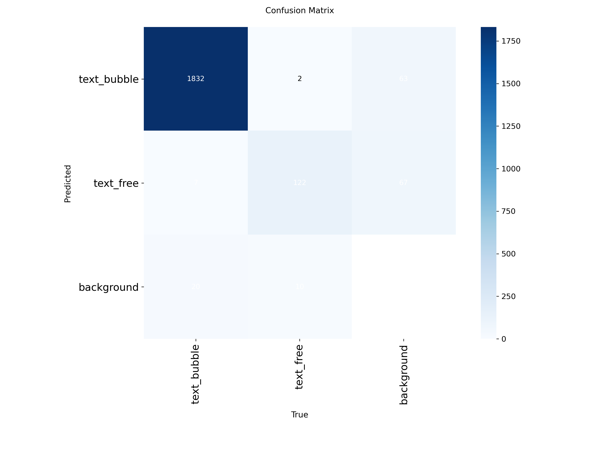

confusion_matrix_normalized


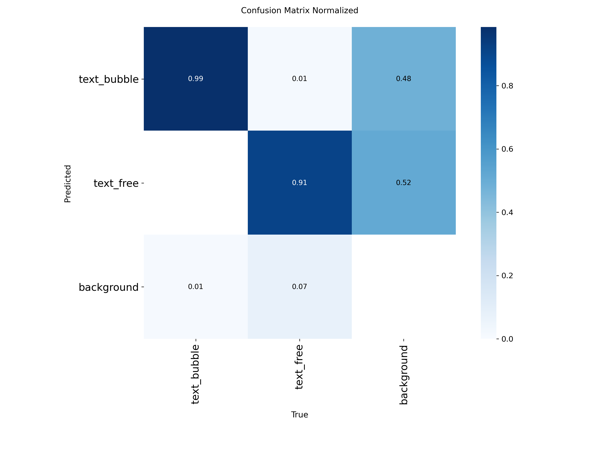

f1_curve


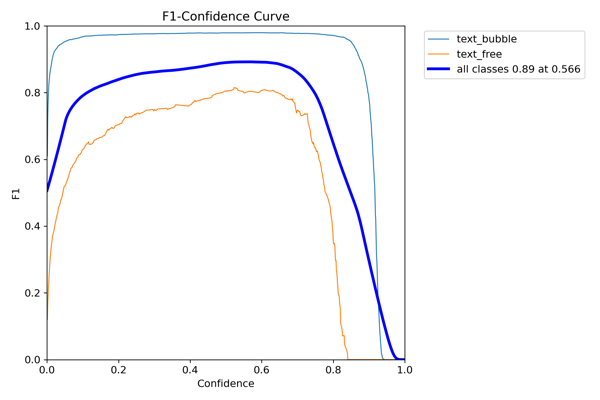

p_curve


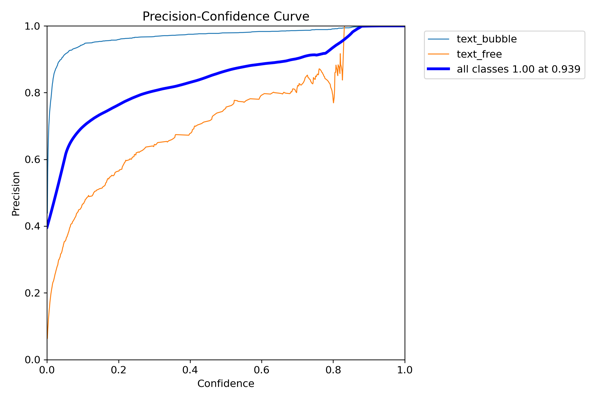

r_curve


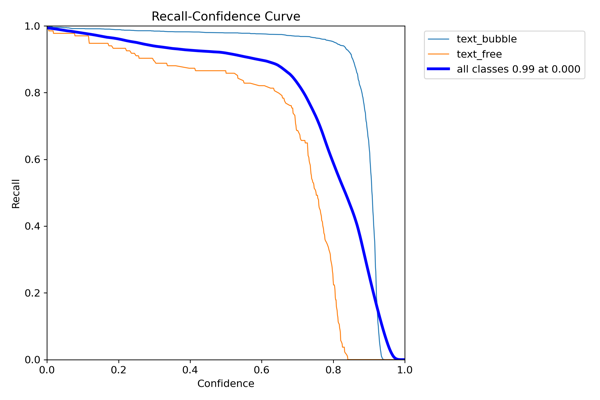

results


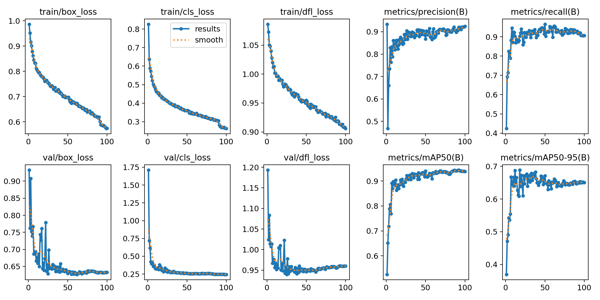

In [9]:
images_dict = {
	"confusion_matrix": f"{best_model_path}/confusion_matrix.png",
	"confusion_matrix_normalized": f"{best_model_path}/confusion_matrix_normalized.png",
	"f1_curve": f"{best_model_path}/F1_curve.png",
	"p_curve": f"{best_model_path}/P_curve.png",
	"r_curve": f"{best_model_path}/R_curve.png",
	"results": f"{best_model_path}/results.png"
}


for title, path in images_dict.items():
	image = Image.open(path)
	image.thumbnail((600, 600))
	print(title)
	display(image)

## Manga OCR

This section will contain the code for extracting text from the speech bubbles in the manga images using `manga-ocr`. But firstly we have to use the previously trained model to detect the speech bubbles in the manga images and then create individual images of the speech bubbles.

In [12]:
import uuid
from PIL import Image
import os

# Get Japanese manga image
image_path = "./00042.jpeg"

image = Image.open(image_path)
bounding_box_images_path = "./bounding_box_images"

# Create the directory if it doesn't exist
if not os.path.exists(bounding_box_images_path):
	os.makedirs(bounding_box_images_path)

# Clear the directory
for file in os.listdir(bounding_box_images_path):
	os.remove(os.path.join(bounding_box_images_path, file))

# Perform inference
result = model.predict(image_path)[0]

for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))
	cropped_image = image.crop(coords)

	# save each image under a unique name
	cropped_image.save(f"{bounding_box_images_path}/{uuid.uuid4()}.png")

image 1/1 /home/riq/src/python/mangatrans/model_creation/00042.jpeg: 640x480 9 text_bubbles, 6.3ms
Speed: 12.8ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
Object: text_bubble
Coordinates: [196, 481, 369, 749]
Probability: 0.9163
Object: text_bubble
Coordinates: [165, 131, 306, 383]
Probability: 0.9126
Object: text_bubble
Coordinates: [529, 508, 689, 753]
Probability: 0.9085
Object: text_bubble
Coordinates: [780, 1064, 1062, 1571]
Probability: 0.8872
Object: text_bubble
Coordinates: [826, 94, 1069, 494]
Probability: 0.859
Object: text_bubble
Coordinates: [847, 496, 1019, 752]
Probability: 0.8415
Object: text_bubble
Coordinates: [791, 734, 959, 1045]
Probability: 0.8406
Object: text_bubble
Coordinates: [263, 1220, 591, 1597]
Probability: 0.8385
Object: text_bubble
Coordinates: [636, 126, 692, 264]
Probability: 0.8063


In [13]:
from manga_ocr import MangaOcr

mocr = MangaOcr()

text_list = []

for image_path in os.listdir(bounding_box_images_path):
	image_path = os.path.join(bounding_box_images_path, image_path)
	text = mocr(image_path)
	print("Image path:", image_path)
	print("Text:", text)
	text_list.append(text)

/home/riq/miniconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-25 19:58:05.460 | INFO     | manga_ocr.ocr:__init__:16 - Loading OCR model from kha-white/manga-ocr-base
2025-05-25 19:59:47.136 | INFO     | manga_ocr.ocr:__init__:22 - Using CUDA
2025-05-25 19:59:48.202 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready


Image path: ./bounding_box_images/ad13ff8a-7301-461c-abd0-48a1328bfd48.png
Text: 不便に思ったり
Image path: ./bounding_box_images/6a61e337-87b3-4b19-b88f-26d66e872d64.png
Text: もっと話したい
Image path: ./bounding_box_images/d4fcd4c0-a817-452a-a96c-6524e3d79293.png
Text: 耳が聴こえなくて：
Image path: ./bounding_box_images/ee6dc4c9-3e99-45da-a6c4-9dc6a83c31eb.png
Text: こんな風に焦がれるのは初めてだ
Image path: ./bounding_box_images/2707c449-7d1e-4c46-b16a-2220c9406162.png
Text: 演奏だって．．．
Image path: ./bounding_box_images/c7df0575-c8c4-4944-9c70-aa92874b8764.png
Text: ちゃんと聴きたかった
Image path: ./bounding_box_images/6d3e1d8f-0e12-4ab4-bd75-003a8b627506.png
Text: ．．．．．．
Image path: ./bounding_box_images/9a12a897-cb3a-4451-84ae-9d54bd0b5c13.png
Text: 悲しくなったり悔しく、なる事は沢山あったけど．．．
Image path: ./bounding_box_images/c2f22ab9-e7d7-4ff1-95da-f0fed55b1f44.png
Text: 咲希と電話したい声を聞きたい


## Deep-translator

This section will contain the code for translating the text extracted from the manga images from Japanese to English using `Deep-translator`.

In [14]:
from deep_translator import GoogleTranslator

for i, text in enumerate(text_list):
	translated_text = GoogleTranslator(source="ja", target="en").translate(text)
	print("Original text:", text)
	print("Translated text:", translated_text)
	text_list[i] = translated_text

Original text: 不便に思ったり
Translated text: I think it's inconvenient
Original text: もっと話したい
Translated text: I want to talk more
Original text: 耳が聴こえなくて：
Translated text: I can't hear my ears:
Original text: こんな風に焦がれるのは初めてだ
Translated text: It's the first time I've been so excited like this
Original text: 演奏だって．．．
Translated text: It's just a performance. . .
Original text: ちゃんと聴きたかった
Translated text: I wanted to listen carefully
Original text: ．．．．．．
Translated text: . . . . . .
Original text: 悲しくなったり悔しく、なる事は沢山あったけど．．．
Translated text: There were many things that made me sad and frustrated. . .
Original text: 咲希と電話したい声を聞きたい
Translated text: I want to hear what I want to call Saki


## Rewrite the text on the manga images

Most manga is written in a certain font style named "AntiGothi", so I will use this font style to rewrite the translated text on the manga images. This font can be downloaded from [this Github repository](https://github.com/Gutenberg-Labo/GL-NovantiquaMinamoto/blob/main/fonts/ttf/GL-NovantiquaMinamoto.ttf).

The following code is rewritten and taken from this [HuggingFace repository](https://huggingface.co/spaces/georgescutelnicu/MangaTranslator/blob/main/) to fit my needs.

In [15]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import textwrap
import cv2

def add_text(image, text, font_path, bubble_contour):
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    x, y, w, h = cv2.boundingRect(bubble_contour)

    line_height = 16
    font_size = 14
    wrapping_ratio = 0.075

    wrapped_text = textwrap.fill(text, width=int(w * wrapping_ratio), 
                                break_long_words=True)
    
    font = ImageFont.truetype(font_path, size=font_size)

    lines = wrapped_text.split('\n')
    total_text_height = (len(lines)) * line_height

    while total_text_height > h:
        line_height -= 2
        font_size -= 2
        wrapping_ratio += 0.025

        wrapped_text = textwrap.fill(text, width=int(w * wrapping_ratio), 
                                break_long_words=True)
                                
        font = ImageFont.truetype(font_path, size=font_size)

        lines = wrapped_text.split('\n')
        total_text_height = (len(lines)) * line_height                         

    # Vertical centering
    text_y = y + (h - total_text_height) // 2

    for line in lines:
        text_length = draw.textlength(line, font=font)

        # Horizontal centering
        text_x = x + (w - text_length) // 2

        draw.text((text_x, text_y), line, font=font, fill=(0, 0, 0))

        text_y += line_height

    image[:, :, :] = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    return image

In [16]:
from typing import Tuple
import cv2
import numpy as np


def process_contour(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Process the contour in the image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, cv2.FILLED)

    image[mask == 255] = (255, 255, 255)

    return image, largest_contour

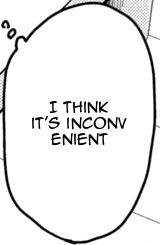

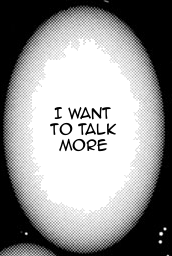

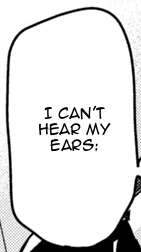

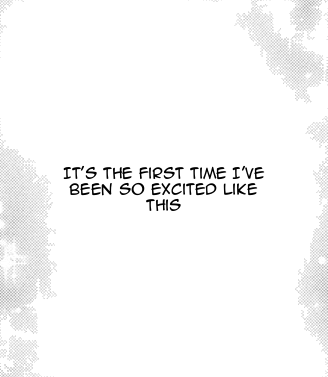

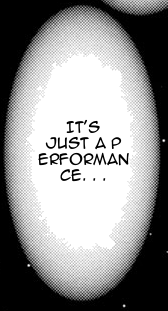

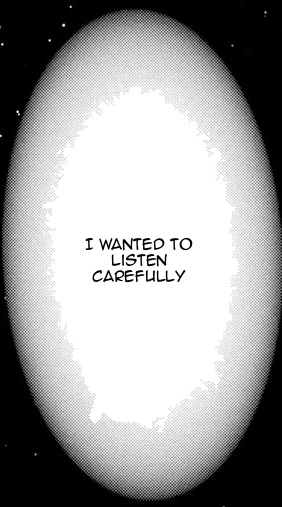

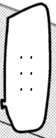

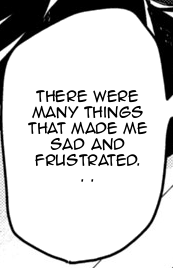

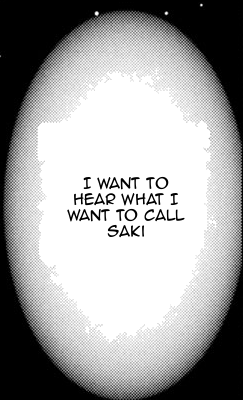

In [17]:
from IPython.display import display
import cv2
import os

manga_font_path = os.path.normpath(os.path.join("../fonts", "mangat.ttf"))

for i, image_path in enumerate(os.listdir(bounding_box_images_path)):
	image_path = os.path.join(bounding_box_images_path, image_path)
	image = cv2.imread(image_path)
	image, contour = process_contour(image)
	text = text_list[i]
	image = add_text(image, text, manga_font_path, contour)
	display(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))


## All in one

This section will contain the code for the entire manga translator pipeline. This pipeline will take a manga image as input and output the translated text from the speech bubbles in the manga image and place the translated text back in the manga image.

/home/riq/miniconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-25 20:24:13.336 | INFO     | manga_ocr.ocr:__init__:16 - Loading OCR model from kha-white/manga-ocr-base
2025-05-25 20:24:16.334 | INFO     | manga_ocr.ocr:__init__:22 - Using CUDA
2025-05-25 20:24:17.516 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready



image 1/1 /home/riq/src/python/mangatrans/model_creation/00042.jpeg: 640x480 9 text_bubbles, 65.7ms
Speed: 2.2ms preprocess, 65.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)
Original text: 悲しくなったり悔しく、なる事は沢山あったけど．．．
Translated text: There were many things that made me sad and frustrated. . .
Original text: 耳が聴こえなくて．．．
Translated text: I can't hear my ears. . .
Original text: 不便に思ったり
Translated text: I think it's inconvenient
Original text: ちゃんと聴きたかった
Translated text: I wanted to listen carefully
Original text: 咲希と電話したい声を聞きたい
Translated text: I want to hear what I want to call Saki
Original text: もっと話したい
Translated text: I want to talk more
Original text: 演奏だって．．．
Translated text: It's just a performance. . .
Original text: こんな風に焦がれるのは初めてだ
Translated text: It's the first time I've been so excited like this
Original text: ．．．
Translated text: 


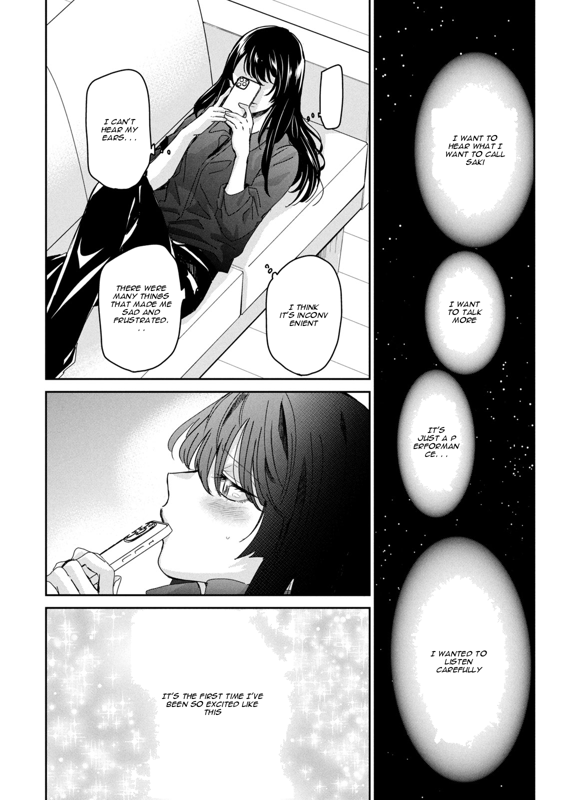

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from PIL import Image
from ultralytics import YOLO
import numpy as np

# Load the object detection model
from utils.predict_bounding_boxes import predict_bounding_boxes
from utils.translate_manga import translate_manga
from utils.manga_ocr_utils import get_text_from_image
from utils.process_contour import process_contour
from utils.write_text_on_image import add_text

image_path = "./00042.jpeg"
image = Image.open(image_path)

# Load the object detection model
best_model_path = "./runs/detect/train"
object_detection_model = YOLO(os.path.join(best_model_path, "weights/best.pt"))

# Predict bounding boxes
results = predict_bounding_boxes(object_detection_model, image_path)
image = np.array(image)

for result in results:
        x1, y1, x2, y2, score, class_id = result
        detected_image = image[int(y1):int(y2), int(x1):int(x2)]
        im = Image.fromarray(np.uint8((detected_image)*255))
        text = get_text_from_image(im)
        detected_image, cont = process_contour(detected_image)
        text_translated = translate_manga(text)
        image_with_text = add_text(detected_image, text_translated, cont)

# Display the translated image
result_image = Image.fromarray(image, 'RGB')
result_image.save('translated_image.png')

# Display the translated image
result_image = Image.open('translated_image.png')
result_image.thumbnail((800, 800))
display(result_image)